In [1]:
from IPython.display import clear_output
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import json
from itertools import product
from tqdm.notebook import tqdm

!git clone https://github.com/chester-i-n/11MH-M.git
!unzip /content/11MH-M/data.zip

clear_output()

# Constants

In [2]:
WORK_DIR = '/content' # Рабочая директория

CLASSES = ['norm', 'dis_1', 'dis_2', 'dis_both'] # Названия классов
SENSORS = ['temp', 'pos_x', 'pos_y', 'accel_x', 'accel_y', 'accel_z'] # Названия датчиков
STRIDES = 10 # Шаг для генерации примеров
N = 100 # Размер примеров
N_CL = len(CLASSES) # Количество классов

# Средние значения измерений по отдельным датчикам
MEAN = torch.tensor([ 1.55861268,  1.05951048,  0.67192477, 
                     0.19552138,  0.06060946, -8.72093948], dtype=torch.float32)

# Стандартное отклонение измерений по отдельным датчикам
STD = torch.tensor([0.03424773, 0.00415722, 0.00476956,
                    0.20554204, 0.97876029, 0.50078193], dtype=torch.float32)

METRIC_NAME = 'accuracy' # Название метрики
METRIC = accuracy_score # Функция расчета метрики
CRITERION = torch.nn.CrossEntropyLoss() # Функция расчета потерь
MODEL_NAME = 'MLP' # Название модели
BATCH_SIZE = 128 # Размер пакетов для обучения
EPOCHS = 100 # Максимальное количество эпох
EARLY_STOP_PATIENCE = 10 # Максимальное количество эпох без улучшения
DECAY = 1e-5 # Коэффициент регуляризации
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Выбор ресурсов для расчета
VERBOSE = True # Флаг для подробного вывода процесса обучения на экран

HYPS = [] # Списко гиперпараметров

hyps = {"learning_rate": [1e-3],
        "scheduler": ["None", "step"],
        "layers": [[128, 128]],
        "dropout": [0, 0.2]}

for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})


# Create datasets

In [3]:
class Dataset(Dataset):
    def __init__(self, folder):
        classes = os.listdir(folder)
        for tar, i in enumerate(classes):
            files = os.listdir(folder + '/' + i)
            for j in files:
                temp = torch.tensor(np.load(folder + '/' + i + '/' + j),
                                    dtype=torch.float32)
                n = int((temp.shape[0] - N) / STRIDES + 1)
                temp_inputs = torch.zeros(n, N, temp.shape[1],
                                          dtype=torch.float32)
                for k in range(n):
                    temp_inputs[k,:,:] = temp[k * STRIDES:k * STRIDES + N].reshape(1,N,temp.shape[1])
                try:
                    self.inputs = torch.cat((self.inputs, temp_inputs), axis = 0)
                    self.targets = torch.cat((self.targets,
                                              torch.ones(n,dtype=torch.int64) * tar), axis = 0)
                except AttributeError:
                    self.inputs = temp_inputs
                    self.targets = torch.ones(n, dtype=torch.int64) * tar
        self.inputs = (self.inputs - MEAN) / STD
        self.inputs = self.inputs.permute(0, 2, 1)
        
        
    def __getitem__(self, idx):

        return self.inputs[idx], self.targets[idx]

    def __len__(self):
        return len(self.targets)

# Create callback for train process

In [4]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.4f}'.format(self.monitor,self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

# Functions for work with model

In [5]:
def predict(model, loader):
    """Make model predictions on loader data.
    
    Args:
        loader (DataLoader): DataLoader with data for predictions.
        model (Model): Current model.
    
    Returns:
        tuple: (act_classes, pred_classes):
            act_classes (list): List of actual classes.
            pred_classes (list): List of predicted classes.
    """
    
    
    model.eval()
    
    act_classes = None
    pred_classes = None
    
    for images, labels in iter(loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        output = model.forward(images)
        
        if act_classes is None:
            act_classes = labels.cpu()
            pred_classes = output.cpu()
        else:
            act_classes = torch.cat((act_classes, labels.cpu()))
            pred_classes = torch.cat((pred_classes, output.cpu()))
    
    model = None
    images = None
    labels = None
    output = None
    sm = None
    
    torch.cuda.empty_cache()
    
    return act_classes, pred_classes


def predict_sample(sample, model):
    """Make model prediction on image.
    
    Args:
        sample (Tensor): Tensor with sample.
        model (Model): Current model.
    
    Returns:
        output (int): indiex of predicted class.
    """
    
    sm = torch.nn.Softmax(dim = 1)

    model.eval()
        
    sample = sample.unsqueeze(0)
    
    image = sample.to(DEVICE)
        
    output = model.forward(image)
    
    model = None
    images = None
    sm = None
    
    torch.cuda.empty_cache()
    
    return sm(output).argmax(dim=1).item()


def evaluate_model(targets, predictions, criterion, metric_fn):
    """Make model evaluation.
    
    Args:
        targets (Model): Ground truth labels.
        predictions (DataLoader): Predictions of model.
        criterion (callable): Function for loss calculation.
        metric_fn (callable): Function for metric calculation.
    
    Returns:
        tuple: (loss, metric):
            loss (float): Value of loss.
            metric (float): Value of metric.
    """
    sm = torch.nn.Softmax(dim = 1)
    out = criterion(predictions, targets), metric_fn(targets, sm(predictions).argmax(dim=1))
    sm = None
    
    return out


def train_classifier(model, train_loader, val_loader, optimizer,
                     criterion, verbose,
                     metric_fn, metric_name,
                     epochs, print_every, callbacks, lr_scheduler):
    """Make model prediction on image.
    
    Args:
        model (Model): Model for training.
        train_loader (DataLoader): loader with train data.
        val_loader (DataLoader): loader with validation data.
        optimizer (Optimizer): Optimizer. 
        criterion (callable): Function for loss calculation.
        metric_fn (callable): Function for metric calculation.
        metric_name (str): Name of metric.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks
    
    Returns:
        history (dict): Dict of lists with train history.
    """
    
    history = {'Train loss':[], 'Train {}'.format(metric_name):[],
               'Val loss':[], 'Val {}'.format(metric_name):[]}
    
    if callbacks:
        for i in callbacks:
            i.start(history, model)
    
    for e in range(epochs):
        model.train()

        running_loss = 0
        running_metric = 0
        
        sm = torch.nn.Softmax(dim = 1)
        
        stop = False
        
        steps = 0
        
        if VERBOSE:
            train_print = ''
            bar = tqdm(range(len(train_loader)), desc="Epoch {}/{}".format(e+1, epochs), postfix=train_print)
        
        for images, labels in iter(train_loader):
            steps += 1
            images, labels = images.to(DEVICE), labels.to(DEVICE)
    
            optimizer.zero_grad()
            output = model.forward(images)
            
            loss = criterion(output, labels)

            loss.backward()
                
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()
                running_metric += metric_fn(labels.cpu(), sm(output).argmax(dim=1).cpu())
            
            if steps % print_every == 0:
                if VERBOSE:
                    train_print = "Train loss: {:.4f}, Train {}: {:.4f}".format(running_loss / steps,
                                                                                metric_name,
                                                                                running_metric / steps)
                    bar.postfix = train_print
                model.train()
            
            if steps != len(train_loader) and VERBOSE:
                bar.update()

        with torch.no_grad():
            targets, predictions = predict(model, val_loader)
            val_loss, val_metric = evaluate_model(targets, predictions, criterion, metric_fn)

        if VERBOSE:
            train_print = "Train loss: {:.4f}, Train {}: {:.4f}, Val loss: {:.4f}, Val {}: {:.4f}".format(
                running_loss / steps,
                metric_name,
                running_metric / steps,
                val_loss,
                metric_name,
                val_metric)
        
        history['Train loss'].append(running_loss / steps)
        history['Train {}'.format(metric_name)].append(float(running_metric / steps))
        history['Val loss'].append(val_loss.item())
        history['Val {}'.format(metric_name)].append(float(val_metric))
        
        if lr_scheduler:
            lr_scheduler.step(val_loss)
        
        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text and VERBOSE:
                    train_print += ', ' + state_text
                if state:
                    stop = True
        if VERBOSE:
            bar.postfix = train_print
            bar.update()
            bar.close()
        
        if stop:
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            images = None
            labels = None
            output = None
            loss = None
            sm = None
            
            torch.cuda.empty_cache()
            
            break
                        
        images = None
        labels = None
        output = None
        loss = None
        sm = None
        
        torch.cuda.empty_cache()
        

    if callbacks:
        for i in callbacks:
            i.stop()
    
    model = None
    
    torch.cuda.empty_cache()
    
    return history


def show_samples(dataset, title):
    """Show samples of dataset with label.
    
    Args:
        dataset (ImageFolder): ImageFolder dataset.
        title (str): Title of images.
    """
    print(title)
    fig, ax = plt.subplots(nrows=N_CL, ncols=len(SENSORS), figsize = (20, 14))
    
    for i in range(N_CL):
        indices = np.arange(len(dataset))
        np.random.shuffle(indices)
        for ind in indices:
            if ind == i:
                break
        for j in range(len(SENSORS)):
            ax[i, j].plot(dataset[i][0][j], c=['r', 'g', 'b', 'c', 'k', 'magenta'][j])
            ax[i, j].set_title(f'class: {CLASSES[i]}, sensor: {SENSORS[j]}')
            ax[i, j].grid(True)
    
    plt.show()


def plot_cm(targets, predictions, title):
    """Show confusion matrix for predictions of model.
    
    Args:
        targets (Model): Ground truth labels.
        predictions (DataLoader): Predictions of model.
        title (str): Title of CM.
    """
    sm = torch.nn.Softmax(dim=1)
    predictions = sm(predictions).argmax(axis=1)
    
    cm  = confusion_matrix(targets, predictions)
    
    plot_confusion_matrix(cm,figsize=(6, 4),cmap=plt.cm.Blues)
    plt.xticks(range(len(CLASSES)), [i for i in CLASSES], fontsize=14)
    plt.yticks(range(len(CLASSES)), [i for i in CLASSES], fontsize=14)
    plt.xlabel('Predicted Label',fontsize=14)
    plt.ylabel('True Label',fontsize=14)
    plt.title(title + " CM")
    plt.show()
    sm = None

    
def plot_train_history(history):
    """Plot train history.
    
    Args:
        history (dict): Dict of lists with train history..
    """
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (16, 12))
    
    ax[0].plot(history['Train loss'], c = 'r')
    ax[0].plot(history['Val loss'], c = 'g')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'])
    
    ax[1].plot(history[f'Train {METRIC_NAME}'], c = 'r')
    ax[1].plot(history[f'Val {METRIC_NAME}'], c = 'g')
    ax[1].set_title(f'{METRIC_NAME}')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel(f'{METRIC_NAME}')
    ax[1].legend(['Train', 'Val'])
    plt.subplots_adjust(hspace=0.3)
    plt.show()

    
def dict2str(dict1):
    out = str(dict1).replace("}", "")
    out = str(out).replace("{", "")
    out = str(out).replace("\"", "")
    out = str(out).replace("\'", "")
    out = str(out).replace(":", "")
    return out

# Create model

In [6]:
class MLP(nn.Module):

    def __init__(self, layers, dropout_rate=0):
        super(MLP, self).__init__()

        inp = [N * len(SENSORS)] + layers[:5]
        self.hidden_layers = nn.Sequential(
            *[nn.Sequential(nn.Dropout(dropout_rate),
                            nn.Linear(i, j, bias=False),
                            nn.BatchNorm1d(j),
                            nn.ReLU(inplace=True)) for i, j in zip(inp, layers)])

        self.classifier = nn.Sequential(nn.Dropout(dropout_rate),
                                        nn.Linear(layers[-1],
                                                  N_CL, bias=True))

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.hidden_layers(x)
        x = self.classifier(x)
        return x

# Train model

Train


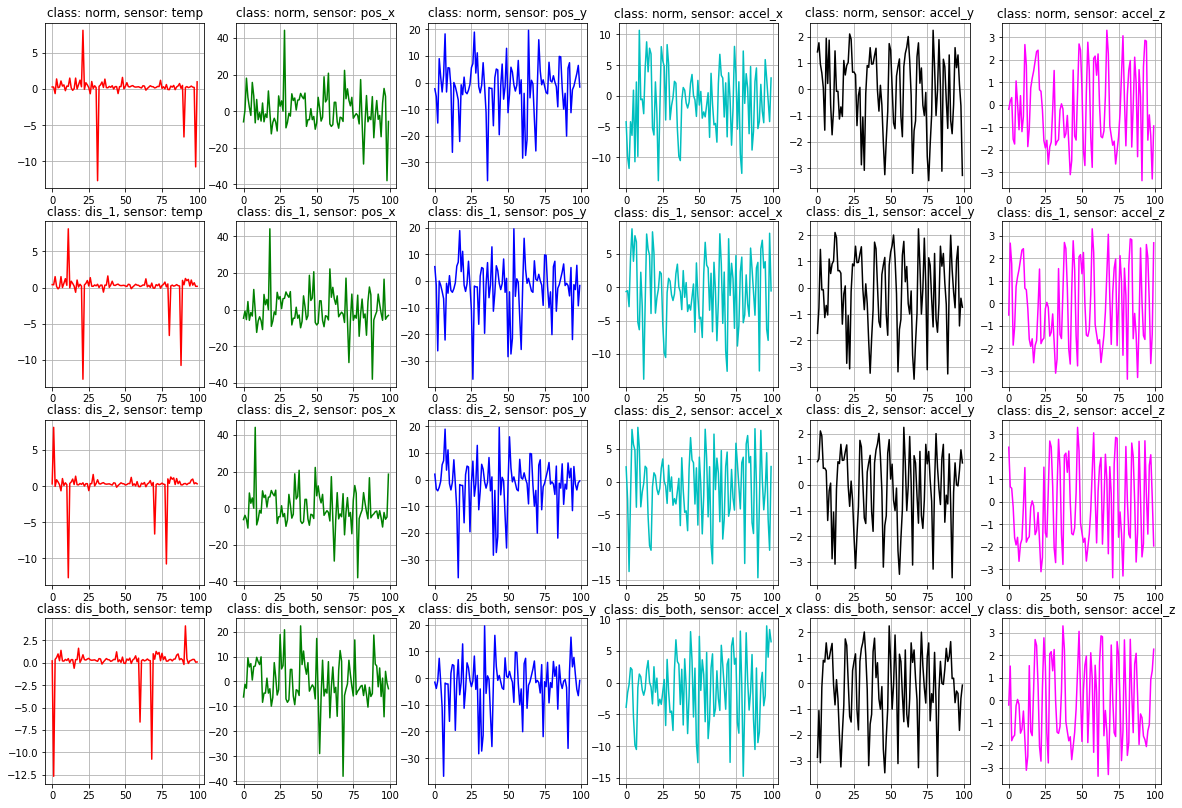

hyperparams: 
 learning_rate 0.001, scheduler None, layers [128, 128], dropout 0


Epoch 1/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/28 [00:00<?, ?it/s]

Best Val accuracy 0.5056
hyperparams: 
 learning_rate 0.001, scheduler None, layers [128, 128], dropout 0.2


Epoch 1/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/28 [00:00<?, ?it/s]

Best Val accuracy 0.6804
hyperparams: 
 learning_rate 0.001, scheduler step, layers [128, 128], dropout 0


Epoch 1/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/28 [00:00<?, ?it/s]

Best Val accuracy 0.5180
hyperparams: 
 learning_rate 0.001, scheduler step, layers [128, 128], dropout 0.2


Epoch 1/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/28 [00:00<?, ?it/s]

Best Val accuracy 0.6422
Best val accuracy: 0.6804, best hyperparams: learning_rate: 0.001, scheduler: None, layers: [128, 128], dropout: 0.2


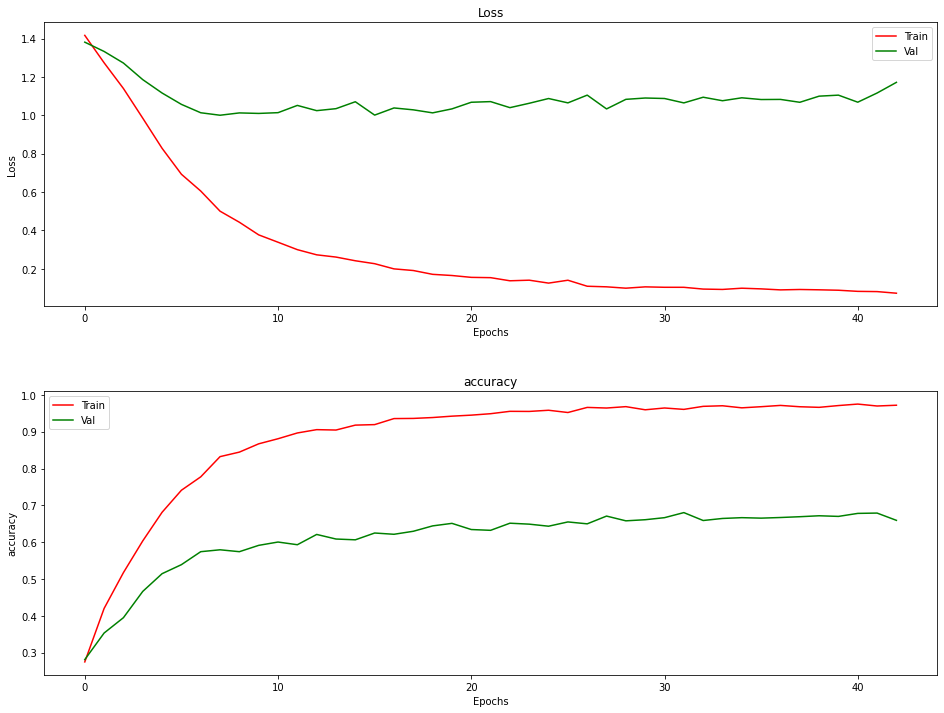

Train loss: 0.0048, Train accuracy: 1.0000


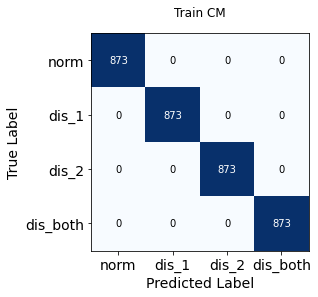

Val loss: 1.0652, Val accuracy: 0.6804


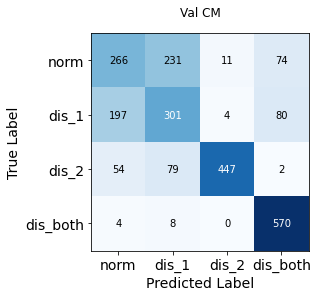

Test loss: 1.3665, Test accuracy: 0.6203


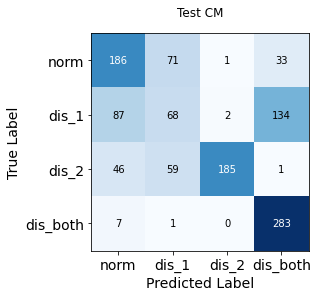

MLP(
  (hidden_layers): Sequential(
    (0): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=600, out_features=128, bias=False)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=128, out_features=128, bias=False)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [7]:
os.makedirs(WORK_DIR + '/models', exist_ok=True)
os.makedirs(WORK_DIR + '/history', exist_ok=True)

train_dataset = Dataset(f'{WORK_DIR}/train')
val_dataset = Dataset(f'{WORK_DIR}/val')
test_dataset = Dataset(f'{WORK_DIR}/test')

show_samples(train_dataset, 'Train')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

run_record = {}
for hyp in HYPS:
    print('hyperparams: \n', dict2str(hyp)) 

    model_path = (f'{WORK_DIR}/models/{MODEL_NAME}_{dict2str(hyp)}')

    callbacks = [EarlyStop(f'Val {METRIC_NAME}', EARLY_STOP_PATIENCE, 'max'),
                 SaveBest(f'Val {METRIC_NAME}', model_path, 'max')]

    model = MLP(hyp['layers'], hyp['dropout'])

    model = model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=hyp["learning_rate"],
                           weight_decay=DECAY)

    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                  mode='min',
                                                                  patience=5,
                                                                  min_lr=1e-6,
                                                                  factor=0.1)
    else:
        lr_scheduler = None

    history = train_classifier(model, train_loader, val_loader, optimizer,
                               CRITERION, verbose=VERBOSE, metric_fn=METRIC,
                               metric_name=METRIC_NAME, epochs=EPOCHS,
                               print_every=10, callbacks=callbacks,
                               lr_scheduler=lr_scheduler)

    run_record[model_path] = {'hyperparams': hyp,
                              'history': history,
                              'final_val_metric': callbacks[1].best_monitor}

    with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
        json.dump(run_record, fp)

    print(f"Best Val {METRIC_NAME} %4.4f" % (callbacks[1].best_monitor))

    model = None
    optimizer = None

    torch.cuda.empty_cache()

best_val_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_val_metric is None or best_val_metric < train_info['final_val_metric']:
        best_val_metric = train_info['final_val_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
    json.dump(run_record, fp)

best_hyp = str(best_hyperparams).replace("}", "")
best_hyp = best_hyp.replace("{", "")
best_hyp = best_hyp.replace("'", "")

print(f"Best val {METRIC_NAME}: %4.4f, best hyperparams: %s" % (best_val_metric,
                                                                best_hyp))

model = MLP(best_hyperparams['layers'], best_hyperparams['dropout'])
model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME}_best.pth')

model = model.to(DEVICE)

plot_train_history(best_run['history'])

with torch.no_grad():
    targets, predictions = predict(model, train_loader)
    loss, metric = evaluate_model(targets, predictions, CRITERION, METRIC)
    print("Train loss: {:.4f}, Train {}: {:.4f}".format(loss, METRIC_NAME, metric))
    plot_cm(targets, predictions, 'Train')

    targets, predictions = predict(model, val_loader)
    loss, metric = evaluate_model(targets, predictions, CRITERION, METRIC)
    print("Val loss: {:.4f}, Val {}: {:.4f}".format(loss, METRIC_NAME, metric))
    plot_cm(targets, predictions, 'Val')

    targets, predictions = predict(model, test_loader)
    loss, metric = evaluate_model(targets, predictions, CRITERION, METRIC)
    print("Test loss: {:.4f}, Test {}: {:.4f}".format(loss, METRIC_NAME, metric))
    plot_cm(targets, predictions, 'Test')

print(model)

train_loader = None
val_loader = None
test_loader = None

train_dataset = None
val_dataset = None